# lab 10 
# implement SVM on the given dataset and evaluate its performance

In [10]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder


# Load dataset
test = pd.read_csv(r'C:/Users/Prakshil/OneDrive/Downloads/test.csv')
train = pd.read_csv(r'C:/Users/Prakshil/OneDrive/Downloads/train.csv')

# Display basic info
print("Shape of test dataset:", test.shape)
print("\nData Types (test):\n", test.dtypes)
print("\nSummary Statistics (test):\n", test.describe())

print("\nShape of train dataset:", train.shape)
print("\nData Types (train):\n", train.dtypes)
print("\nSummary Statistics (train):\n", train.describe())

Shape of test dataset: (367, 12)

Data Types (test):
 Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

Summary Statistics (test):
        ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       367.000000         367.000000  362.000000        361.000000   
mean       4805.599455        1569.577657  136.132597        342.537396   
std        4910.685399        2334.232099   61.366652         65.156643   
min           0.000000           0.000000   28.000000          6.000000   
25%        2864.000000           0.000000  100.250000        360.000000   
50%        3786.000000        1025.000000  125.000000        360.000000   
75%        5060.000000        

In [11]:
train_data = pd.read_csv(r"C:/Users/Prakshil/OneDrive/Downloads/train.csv")
train_data = train_data.dropna(subset=['Loan_Status'])


le_target = LabelEncoder()
train_data['Loan_Status'] = le_target.fit_transform(train_data['Loan_Status'])


X = train_data.drop('Loan_Status', axis=1)
y = train_data['Loan_Status']


for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))


X = X.fillna(X.median())


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
   
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_pred_prob = None
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        scores = model.decision_function(X_test)
        y_pred_prob = MinMaxScaler().fit_transform(scores.reshape(-1,1)).ravel()

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else "N/A"

    print(f"\n==== {model_name} Evaluation ====")
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-Score:", f1)
    print("ROC AUC Score:", roc_auc)
    
    # Confusion Matrix Plot - FIXED
    plt.figure(figsize=(6,5))  # Increased figure size
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()  # ADD THIS LINE - automatically adjusts spacing
    plt.show()

    # ROC Curve Plot
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
        plt.plot([0,1], [0,1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend()
        plt.tight_layout()  # ADD THIS LINE too
        plt.show()



==== Stacking Classifier Evaluation ====
Confusion Matrix:
 [[23 20]
 [14 66]]
Accuracy: 0.7235772357723578
Precision: 0.7674418604651163
Recall: 0.825
F1-Score: 0.7951807228915663
ROC AUC Score: 0.670203488372093


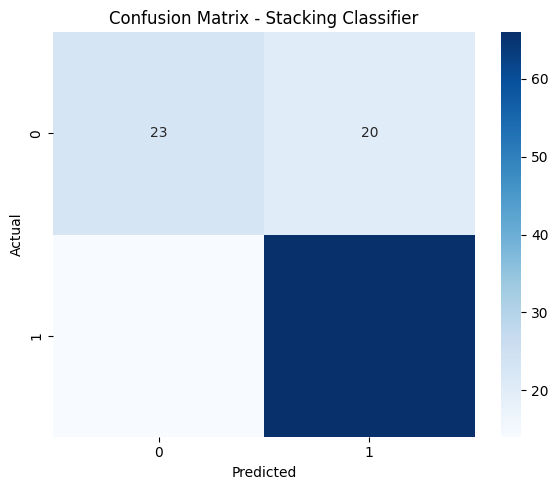

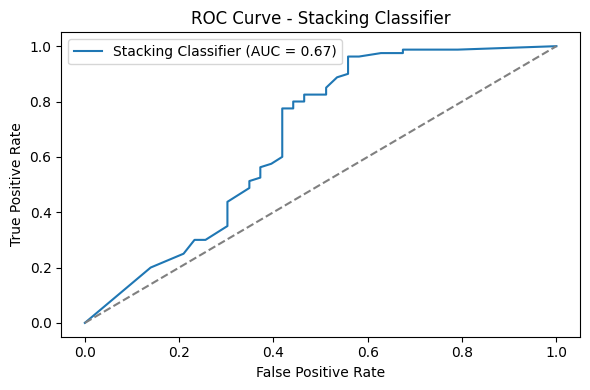

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]


meta_model = RandomForestClassifier(n_estimators=100, random_state=42)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

stack_model.fit(X_train_scaled, y_train)
y_pred = stack_model.predict(X_val_scaled)
y_prob = stack_model.predict_proba(X_val_scaled)[:, 1]

evaluate_model(stack_model, X_train_scaled, X_val_scaled, y_train, y_val, model_name="Stacking Classifier")



==== SVM Classifier Evaluation ====
Confusion Matrix:
 [[18 25]
 [ 0 80]]
Accuracy: 0.7967479674796748
Precision: 0.7619047619047619
Recall: 1.0
F1-Score: 0.8648648648648649
ROC AUC Score: 0.6857558139534884


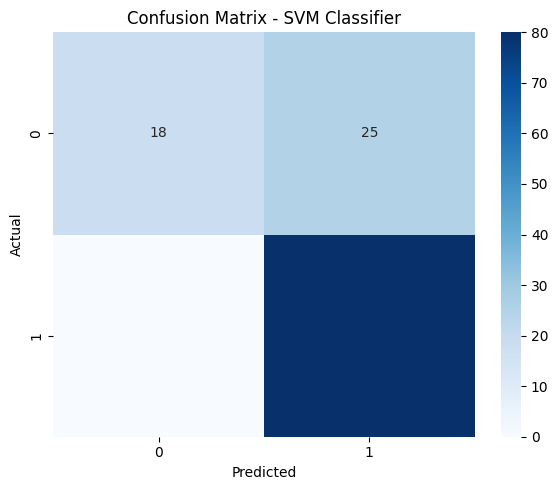

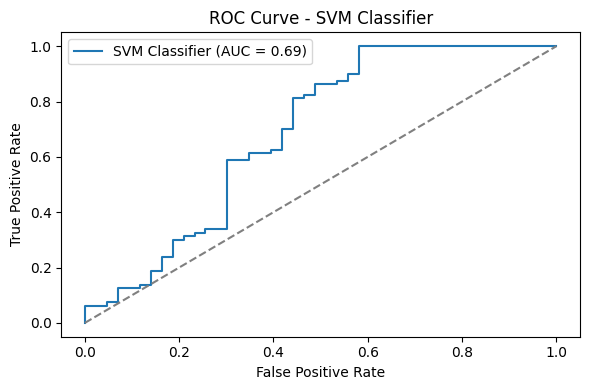

In [13]:
# Update the SVM cell to use scaled data
from sklearn.svm import SVC

# Create SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Use scaled data for SVM (it performs better with normalized features)
evaluate_model(svm_model, X_train_scaled, X_val_scaled, y_train, y_val, model_name="SVM Classifier")